# assignment_1b question 3

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 3: N-Layer and Dropout](#n_layer_and_dropout)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Try Test Set](#try_test_set) 
        * [5-Layer](#5_layer)
        * [5-Layer Dropout](#5_layer_dropout)    
        * [4-Layer](#4_layer)    
        * [4-Layer Dropout](#4_layer_dropout)        
        * [3-Layer](#3_layer)     
        * [Save Data Objects](#save_data_objects)
        * [Plot Model Performance](#plot_model_performance)
        * [Comparing Models](#comparing_models)
        * [Eyeballing Network and Dropout](#eyeballing_rfe_feature_space)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import itertools

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [4]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [5]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### histories_loader()

In [6]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### TestCallback()

In [7]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, mse = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['mse'].append(mse)
        histories_test['test_values']['loss'].append(loss)

# Question 3: N-Layer and Dropout  <a name="n_layer_and_dropout"></a>
[Back to top](#toc)

<i>Design a four-layer neural network and a five-layer neural network, with the hidden layers having 50 neurons each. Use a learning rate of 10-3 for all layers and optimal feature set selected in part (3). Introduce dropouts (with a keep probability of 0.8) to the layers and report the accuracies. Compare the performances of all the networks (with and without dropouts) with each other and with the 3-layer network.</i>

Essentially we have to build five networks on the optimal feature set from assignment_1b_q2
* 3-layer network no dropout (from assignment_1b_q2)
* 4-layer network no dropout
* 4-layer network with dropout
* 5-layer network no dropout
* 5-layer network with dropout

There may be some trouble later when evaluating these five models, since the 3-layer network in assignment_1b_q2 was built with 10 neurons

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [8]:
num_neurons = 50 # for 4-layer, 5-layer

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)
dropout_rate = 0.2

learning_rate= 10e-3
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
metrics = ['mse']

validation_split = 0.3
epochs = 400 # from assignment_1b_q1
batch_size = 8

print("Model Parameters set")

Model Parameters set


The optimal feature set from assignment_1b q2 is a 6 input feature set, which dropped ```SOP```, the 4th column. We shall truncate the data as such 

In [9]:
# from assignment_1b_q2
X_train_truncated = np.delete(X_train, 3, 1)
X_test_truncated = np.delete(X_test, 3, 1)
print("X_train_truncated, X_test_truncated generated")

X_train_truncated, X_test_truncated generated


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [10]:
def create_model_3(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_4(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_4_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_5(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_5_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [11]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

# Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

In [12]:
def train_set_histories_objects(): 
    # the history object to keep performance of X_test Y_test from final model
    histories_test = {
        'test_values': {
            'loss': [],
            'mse': []
        }
    }

    # the history object to keep performance of X_train Y_train from final model
    histories_model = {}
    
    return histories_test, histories_model

In [13]:
def train_set_histories_objects_save(histories_test, histories_model, histories_model_filename):
    histories_saver(histories_model, histories_model_filename)
    histories_model = histories_loader(histories_model_filename)

    histories_model['test_values'] = histories_test['test_values']

    histories_saver(histories_model, histories_model_filename, already_json=True)
    histories_model = histories_loader(histories_model_filename)
    
    return histories_model

In [14]:
histories_final = {}

### 5-Layer <a name="5_layer"></a> 
[Back to top](#toc)

In [15]:
# the parameter to be changed for the model
num_neurons = 50

model = create_model_5(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '5_layer_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 
histories_model_filename = "data/q3_histories_model_5_layer_test.json"

model_5_layer_test, histories_model['train_values'] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  5_layer_test

Histories saved
Histories loaded
Histories saved
Histories loaded


### 5-Layer Dropout <a name="5_layer_dropout"></a> 
[Back to top](#toc)

In [16]:
# the parameter to be changed for the model
num_neurons = 50

model = create_model_5_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '5_layer_dropout_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 
histories_model_filename = "data/q3_histories_model_5_layer_dropout_test.json"

model_5_layer_dropout_test, histories_model['train_values'] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  5_layer_dropout_test

Histories saved
Histories loaded
Histories saved
Histories loaded


### 4-Layer <a name="4_layer"></a> 
[Back to top](#toc)

In [17]:
# the parameter to be changed for the model
num_neurons = 50

model = create_model_4(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '4_layer_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 
histories_model_filename = "data/q3_histories_model_4_layer_test.json"

model_4_layer_test, histories_model['train_values'] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  4_layer_test

Histories saved
Histories loaded
Histories saved
Histories loaded


### 4-Layer Dropout <a name="4_layer_dropout"></a> 
[Back to top](#toc)

In [18]:
# the parameter to be changed for the model
num_neurons = 50

model = create_model_4_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '4_layer_dropout_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 
histories_model_filename = "data/q3_histories_model_4_layer_dropout_test.json"

model_4_layer_dropout_test, histories_model['train_values'] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  4_layer_dropout_test

Histories saved
Histories loaded
Histories saved
Histories loaded


### 3-Layer <a name="3_layer"></a> 
[Back to top](#toc)

The 3-layer network only differs in ```num_neurons=10``` and having no dropout

In [19]:
# the parameter to be changed for the model
num_neurons = 10

model = create_model_3(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '3_layer_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 
histories_model_filename = "data/q3_histories_model_3_layer_test.json"

model_3_layer_test, histories_model['train_values'] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  3_layer_test

Histories saved
Histories loaded
Histories saved
Histories loaded


##### Plotting Test Set

In [20]:
histories_saver(histories_final, "data/q3_histories_final.json", already_json=True)
histories_final = histories_loader("data/q3_histories_final.json")

Histories saved
Histories loaded


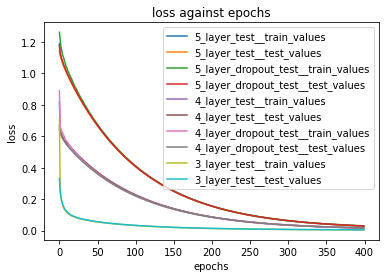

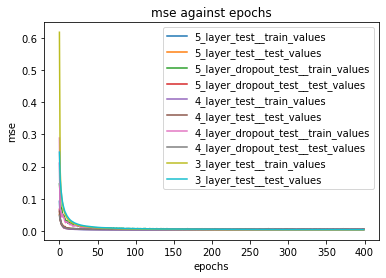

In [21]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        for value_type in histories_final[model_name].keys():
            plt.plot(histories_final[model_name][value_type][history_object], label=model_name + '__' + value_type)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

Zooming in on the head (first 50 epochs) and just focusing on the test_values

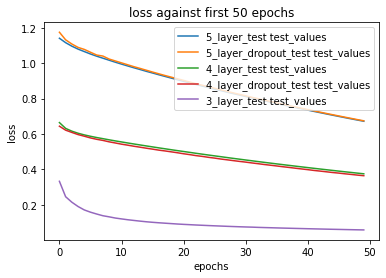

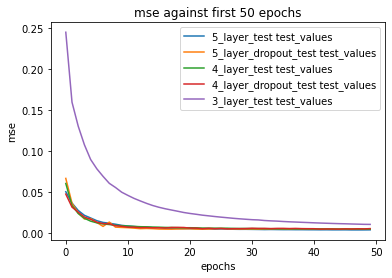

In [22]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name]['test_values'][history_object][:50], label=model_name + ' ' + value_type)
#         for value_type in histories_final[model_name].keys():
#             plt.plot(histories_final[model_name][value_type][history_object][-15:], label=model_name + ' ' + value_type)

    plt.title(history_object + ' against first 50 epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

Zooming in on the tail (last 50 epochs) and just focusing on the test_values

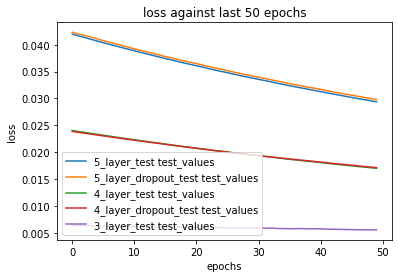

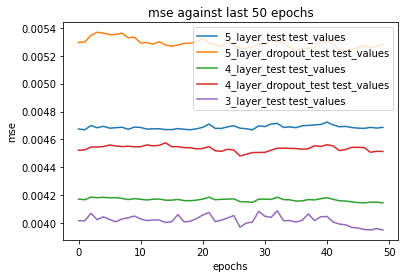

In [29]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name]['test_values'][history_object][-50:], label=model_name + ' ' + value_type)
#         for value_type in histories_final[model_name].keys():
#             plt.plot(histories_final[model_name][value_type][history_object][-15:], label=model_name + ' ' + value_type)

    plt.title(history_object + ' against last 50 epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

> ### ```3-layer, 10 neurons, no dropout``` has the best model that generalizes to the test set

It has the smallest loss and mse values out of all the models.

> ### more layers, or more neurons/layer helps early on

We can see that in the first 50 epochs, the 4-layer and 5-layer networks had significantly lower ```mse``` than the 3-layer network. This is likely because the increased layer count and neuron count allowed the networks to learn much faster than a 3-layer network

> ### more layers, or more neurons/layer did not help later on

The greater the layer count, the worse it performed later on. This might be a sign of overfitting over the data set since the entire data set is just 400 rows, and the training set is 280 rows.

> ### dropout did not help much

For the 4-layer and 5-layer networks, those that implemented dropout fared worse than those that did not. It might be the case  that either 

1. dropout too much, which causes more information loss than it should have and therefore underfitting
2. dropout not enough, thus the model is still overfitting


##### Visualize Test Predictions <a name="visualize_test_predictions"></a> 
[Back to top](#toc)

In [24]:
Y_test_pred_5 = model_5_layer_test.predict(X_test_truncated)
Y_test_pred_5 = Y_test_pred_5.reshape(1,120)[0]

Y_test_pred_5_dropout = model_5_layer_dropout_test.predict(X_test_truncated)
Y_test_pred_5_dropout = Y_test_pred_5_dropout.reshape(1,120)[0]

Y_test_pred_4 = model_4_layer_test.predict(X_test_truncated)
Y_test_pred_4 = Y_test_pred_4.reshape(1,120)[0]

Y_test_pred_4_dropout = model_4_layer_dropout_test.predict(X_test_truncated)
Y_test_pred_4_dropout = Y_test_pred_4_dropout.reshape(1,120)[0]

Y_test_pred_3 = model_3_layer_test.predict(X_test_truncated)
Y_test_pred_3 = Y_test_pred_3.reshape(1,120)[0]

In [25]:
df_Y_test_pred_5 = pd.DataFrame(Y_test_pred_5, columns =['Y_test_pred_5']) 
df_Y_test_pred_5_dropout = pd.DataFrame(Y_test_pred_5_dropout, columns =['Y_test_pred_5_dropout']) 
df_Y_test_pred_4 = pd.DataFrame(Y_test_pred_4, columns =['Y_test_pred_4']) 
df_Y_test_pred_4_dropout = pd.DataFrame(Y_test_pred_4_dropout, columns =['Y_test_pred_4_dropout']) 
df_Y_test_pred_3 = pd.DataFrame(Y_test_pred_3, columns =['Y_test_pred_3']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred_5, df_Y_test_pred_5_dropout, df_Y_test_pred_4, df_Y_test_pred_4_dropout, df_Y_test_pred_3, df_Y_test], axis=1)

In [26]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred_5,Y_test_pred_5_dropout,Y_test_pred_4,Y_test_pred_4_dropout,Y_test_pred_3,Y_test
45,0.743482,0.740773,0.739177,0.737555,0.723577,0.77
79,0.567236,0.574625,0.532021,0.548207,0.481833,0.44
56,0.735969,0.731984,0.733694,0.730316,0.715998,0.75
85,0.662250,0.672826,0.666535,0.671848,0.656134,0.62
99,0.661830,0.672917,0.650906,0.656452,0.639381,0.50


##### First view: plotting pred+ground_truth pairs

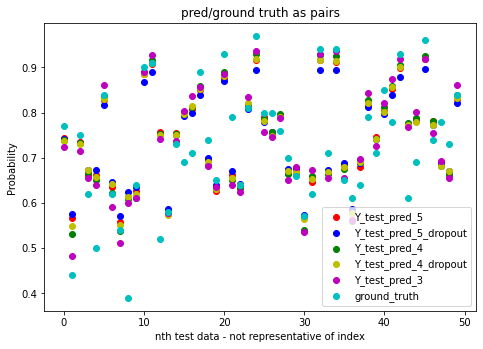

In [27]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_5'], color='r', label='Y_test_pred_5')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_5_dropout'], color='b', label='Y_test_pred_5_dropout')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_4'], color='g', label='Y_test_pred_4')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_4_dropout'], color='y', label='Y_test_pred_4_dropout')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_3'], color='m', label='Y_test_pred_3')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='c', label='ground_truth')

ax.set_title('pred/ground truth as pairs')
ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Second view: predicted value against ground truth

If a datapoint lies on the y=x line, it represents a perfect prediction

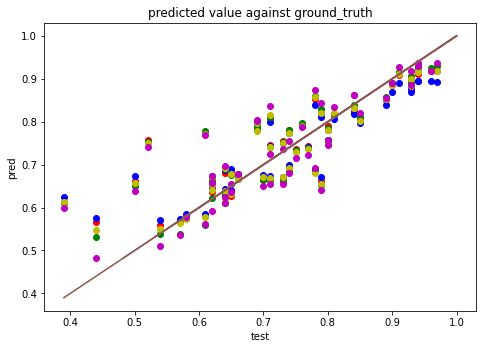

In [28]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_5'], color='r')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_5_dropout'], color='b')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_4'], color='g')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_4_dropout'], color='y')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_3'], color='m')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))

ax.set_title('predicted value against ground_truth')
ax.set_xlabel('test')
ax.set_ylabel('pred')
plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> Optimal model is with a 3-layer network, 10 neurons/layer, no dropout

Of course, this combination is due to the question. There might be better networks, just that we have not tried the combinations yet